# Installing kaggle dataset into Colab 

In [0]:
!pip install kaggle

In [0]:
from google.colab import files
files.upload() #choose files to upload in dropbox

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#Change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [6]:
#Extracting the zip file to download the csv files
from zipfile import ZipFile
file_name="chest-xray-pneumonia.zip"
with ZipFile(file_name,'r') as zip:
  print('Extracting file...')
  zip.extractall()
  print('Done')

Extracting file...
Done


# Importing required Libraries

In [7]:
import numpy as np # forlinear algebra
import matplotlib.pyplot as plt #for plotting
import os
from PIL import Image

# Keras Libraries
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


# Exploring the dataset

In [0]:
train_dir='/content/chest_xray/train/'
test_dir='/content/chest_xray/test/'
val_dir='/content/chest_xray/val/'

In [9]:
#will show names of the two files inside
os.listdir(train_dir) 

['PNEUMONIA', 'NORMAL']

In [0]:
#two different ways to move inside directories
train_n = train_dir + 'NORMAL/'
train_p = os.path.join(train_dir,'PNEUMONIA/')

In [11]:
#Number of images in both cases
print('Total normal images:',len(os.listdir(train_n)))
print('Total Pneumonia images:',len(os.listdir(train_p)))

Total normal images: 1341
Total Pneumonia images: 3875


**We can see that number of sample images for normal patients is less than number of pneumonia detected patients.
We will use data augmentation later to reduce overfitting.**

**For now, we will look at samples of both the normal images and the pneumonia images**

normal picture title:  NORMAL2-IM-1158-0001.jpeg
pneumonia picture title: person1026_virus_1718.jpeg


Text(0.5, 1.0, 'Pneumonia')

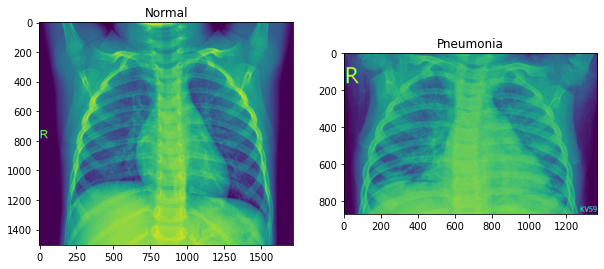

In [12]:
#Selecting random Normal pic 
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
print('normal picture title: ',norm_pic)
norm_pic_address = train_n + norm_pic
#Selecting random Pneumonia pic
rand_p = np.random.randint(0,len(os.listdir(train_p)))
pneum_pic =  os.listdir(train_p)[rand_norm]
print('pneumonia picture title:', pneum_pic)
pneum_pic_address = train_p + pneum_pic
## Loading the images
norm_load = Image.open(norm_pic_address)
pneum_load = Image.open(pneum_pic_address)
## Plotting images
fig = plt.figure(figsize= (10,8))
p1 = fig.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
p1.set_title('Normal')

p2 = fig.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneum_load)
p2.set_title('Pneumonia')

We will rescale those images and convert the images into grayscale before fitting the images to the model.

# Data Augmentation

Before feeding our data to the model we need to do  rescaling, rotation, shearing and zooming.

In [0]:
training_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip = True, shear_range=0.2, zoom_range=0.2)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Now we will load the dataset using "flow_from_directory" function.

In [74]:
training_set = training_datagen.flow_from_directory('/content/chest_xray/chest_xray/train/', ##train_dir
                                                    target_size = (64, 64),
                                                    batch_size = 32,
                                                    class_mode = 'binary',
                                                    color_mode='grayscale')

valid_set = valid_datagen.flow_from_directory('/content/chest_xray/chest_xray/val/',
                                              target_size=(64, 64),
                                              batch_size=32,
                                              class_mode='binary',
                                              color_mode='grayscale')
test_set = test_datagen.flow_from_directory('/content/chest_xray/chest_xray/test',
                                            target_size = (64, 64),
                                            batch_size = 1,
                                            class_mode = None,
                                            color_mode='grayscale',
                                            shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Building the CNN Model

I have built a CNN with 2 Convolution layers with non linear activation funcition(ReLU). I have also added a Pooling layer(MaxPooling) after each convolution layer. At the output of the second convolutional layer we get a feature map which we will pass through two fully connected layers to make predictions.

In [0]:
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'sigmoid', units = 1))

cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [86]:
cnn_model = cnn.fit_generator(training_set,
                              steps_per_epoch = 5216//32,
                              epochs = 3,
                              validation_data = valid_set,
                              validation_steps = 64)

Epoch 1/3
163/163 [==============================] - 66s 404ms/step - loss: 0.0892 - accuracy: 0.9672 - val_loss: 0.4405 - val_accuracy: 0.8125
Epoch 2/3
163/163 [==============================] - 62s 382ms/step - loss: 0.0929 - accuracy: 0.9661 - val_loss: 0.2128 - val_accuracy: 0.8750
Epoch 3/3
163/163 [==============================] - 62s 383ms/step - loss: 0.0929 - accuracy: 0.9655 - val_loss: 0.2992 - val_accuracy: 0.9375


In [0]:
test_accuracy = cnn.evaluate_generator(test_set)
print(test_accuracy[1])

In [88]:
Y_pred = cnn.predict_generator(test_set)
y_pred = np.round(Y_pred, decimals=0)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
#target_names = ['Normal','Pneumonia']
print(classification_report(test_set.classes, y_pred))# target_names=target_names))


Confusion Matrix
[[173  61]
 [  4 386]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       234
           1       0.86      0.99      0.92       390

    accuracy                           0.90       624
   macro avg       0.92      0.86      0.88       624
weighted avg       0.91      0.90      0.89       624



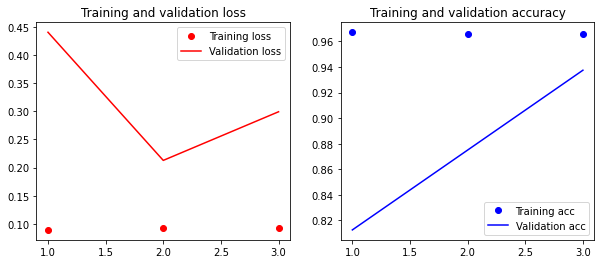

In [89]:
acc = cnn_model.history['accuracy']
val_acc = cnn_model.history['val_accuracy']
loss = cnn_model.history['loss']
val_loss = cnn_model.history['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()